# This notebook is used to generate the data and analyses of the background section of my master's thesis

In [161]:
# Imports
import numpy
import adaptive_nof1
import pandas
import scipy.stats as stats
import seaborn
import pymc
import arviz

In [156]:
# Generate data:
rng = numpy.random.default_rng(42) # Use a seed to be reproducible

n_patients = 10
n_treatments = 2
treatment_sequence = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

mean_effect_patients_treatment_1 = rng.normal(1,0.7, size=n_patients)
mean_effect_patients_treatment_2 = rng.normal(0,0.7, size=n_patients)

outcomes_treatment_1 = rng.normal(mean_effect_patients_treatment_1, 1, size=(5, len(mean_effect_patients_treatment_1)))
outcomes_treatment_2 = rng.normal(mean_effect_patients_treatment_2, 1, size=(5, len(mean_effect_patients_treatment_2)))
df = pandas.concat([pandas.DataFrame(outcomes_treatment_1), pandas.DataFrame(outcomes_treatment_2)])
df["t"] = range(10)
df.set_index("t")
df["intervention"] = treatment_sequence

print(mean_effect_patients, mean_effect_patients_treatment_2)

[ 1.58907299  0.86078442 -0.26435342  1.29978205  1.97107713 -0.21770459
 -0.57371769  0.33340148  0.25572596  1.92961595] [ 0.61557858  0.54445435  0.04622149  0.78906884  0.32725654 -0.60150472
  0.25812555 -0.67121782  0.61491521 -0.03494814]


In [157]:
df = df[["t", "intervention", 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]

In [158]:
# Export the DataFrame to a LaTeX table
latex_table = df.to_latex(index=False, float_format='%.1f')
# Print or save the LaTeX table to a .tex file
print(latex_table)

with open('mt_resources/2-background/background_example_data.tex', 'w') as f:
    f.write(latex_table)

\begin{tabular}{rrrrrrrrrrrr}
\toprule
t & intervention & 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 \\
\midrule
0 & 0 & 1.0 & -0.4 & 2.7 & 1.5 & -0.8 & -0.3 & 1.6 & 1.1 & 1.4 & 0.8 \\
1 & 0 & 3.4 & -0.1 & 1.0 & 0.8 & 0.3 & 1.2 & 1.0 & -0.1 & 0.2 & 1.1 \\
2 & 0 & 2.0 & 0.8 & 0.9 & 1.9 & -0.2 & 0.3 & 2.0 & 1.0 & 1.7 & 0.5 \\
3 & 0 & 1.5 & 0.9 & 0.1 & 1.3 & -0.8 & -0.6 & 0.8 & 2.3 & 0.1 & 1.4 \\
4 & 0 & -0.5 & -0.1 & 1.7 & 2.2 & 0.3 & 0.9 & 0.7 & 0.3 & 1.8 & 0.2 \\
5 & 1 & -0.7 & -0.6 & -0.9 & 1.3 & 0.5 & 0.1 & -0.2 & -0.5 & 1.2 & -0.3 \\
6 & 1 & 1.1 & -0.1 & -0.3 & 0.4 & -0.9 & -0.1 & -0.2 & -0.7 & 1.1 & 0.4 \\
7 & 1 & 1.3 & 0.4 & -0.4 & 0.7 & -1.4 & -2.0 & -1.1 & -1.7 & 1.0 & -0.9 \\
8 & 1 & 0.2 & 1.8 & -0.3 & 1.5 & -0.6 & -0.8 & -0.7 & -1.0 & 1.5 & -1.8 \\
9 & 1 & 1.1 & 0.8 & -0.5 & -0.7 & 0.4 & -1.1 & 0.5 & -0.6 & 2.2 & -0.3 \\
\bottomrule
\end{tabular}



In [149]:
# Plot the posterior of m_{0,0} and m_{0, 1} given the condition on only the data for patient one
n = numpy.array([5, 5])
sigma_squared_0 = numpy.array([1, 1])
sigma_squared = numpy.array([1,1])
sigma_squared_n = 1 / ((n / sigma_squared) + 1 / sigma_squared_0)
mu_0 = numpy.array([0, 0])

means_of_observations = df.groupby("intervention")[0].mean().to_numpy()

mu_n = sigma_squared_n * (mu_0 / sigma_squared_0 + (5 * means_of_observations) / sigma_squared)
print(f"mu_n {mu_n}")
print(f"sigma_squared {sigma_squared_n}")

mu_n [1.2287998  0.49677134]
sigma_squared [0.16666667 0.16666667]


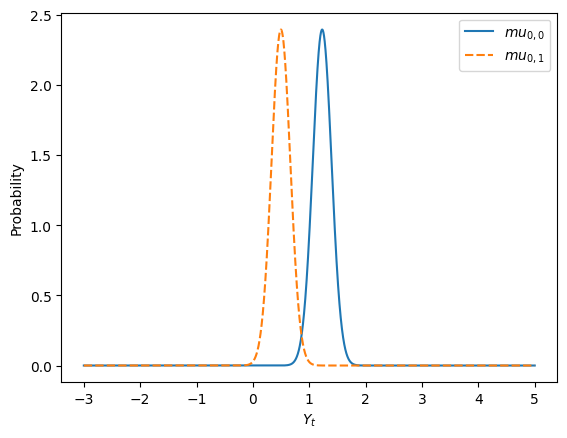

In [150]:
# plot posterior predictive for mu
x = np.linspace(-3, 5.0, 10000)
y_0 = stats.norm.pdf(x, mu_n[0], sigma_squared_n[0])
y_1 = stats.norm.pdf(x, mu_n[1], sigma_squared_n[1])
df = pandas.DataFrame({"$Y_t$": x, "$mu_{0,0}$": y_0, "$mu_{0,1}$": y_1})
df.set_index("$Y_t$", inplace=True)
seaborn.lineplot(df)
plt.ylabel("Probability")
plt.savefig("mt_resources/2-background/mean_posteriors.pdf", bbox_inches="tight")

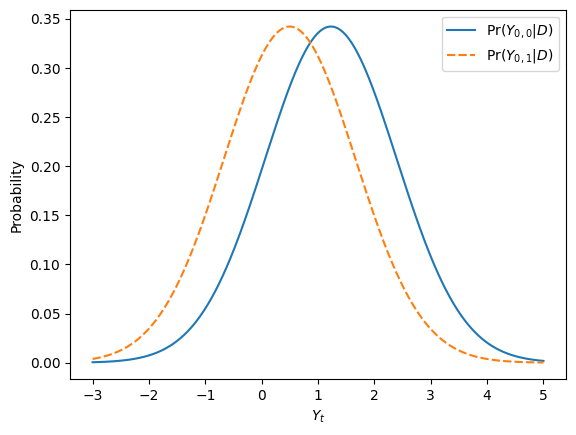

In [151]:
# plot posterior predictive for outcome Pr(x | D)
x = np.linspace(-3, 5.0, 10000)
y_0 = stats.norm.pdf(x, mu_n[0], sigma_squared_n[0] + sigma_squared[0])
y_1 = stats.norm.pdf(x, mu_n[1], sigma_squared_n[1] + sigma_squared[0])
df = pandas.DataFrame({"$Y_t$": x, "$\Pr(Y_{0,0} | D)$": y_0, "$\Pr(Y_{0,1} | D)$": y_1})
df.set_index("$Y_t$", inplace=True)
seaborn.lineplot(df)
plt.ylabel("Probability")
plt.savefig("mt_resources/2-background/outcome_posteriors.pdf", bbox_inches="tight")

In [160]:
# Model code for one patient
model = pymc.Model()
with model:
    treatment_index = pymc.MutableData("treatment_index", pymc.intX(df["intervention"]), dims="observation")
    patient_index = 0
    mu_ik = pymc.Normal("mu_ik", mu=0, sigma=1, dims="treatment", shape=2)
    outcome = pymc.Normal(
        "outcome", mu=mu_ik[treatment_index], observed=df[patient_index], sigma=1, dims="observation", shape=len(df[patient_index]),
    )
    trace = pymc.sample(2000, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_ik]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


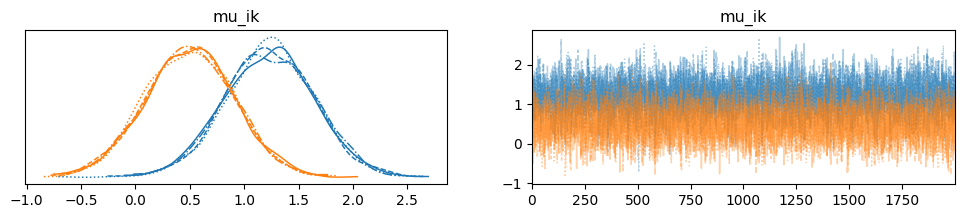

In [165]:
arviz.plot_trace(trace)plt.savefig("mt_resources/2-background/plot_trace.pdf", bbox_inches="tight")